In [1]:
# plotting libraries
import matplotlib
import matplotlib.pyplot as plt 
# numpy (math) libary
import numpy as np

from os import walk

path1 = '../../../data/'

# torch library and sublibraries
import torch
from torch.autograd import Variable

In [2]:
f = [] # empty list of files
for (dirpath, dirnames, filenames) in walk(path1):
    f.extend(filenames)

# sort list alphabetically
f.sort()
# remove non .ssv files from list
f = [x for x in f if x[-4:]==".ssv"]

In [3]:
print('list of input files:\n* ',f)

temp = np.loadtxt(path1+f[0])
data = {}

data['x'] = np.copy(temp)[:,3:-1]
data['c'] = np.copy(temp)[:,-1]

print('\ninput data has shape:\tx ',  data['x'].shape)
print('target data has shape:\tc ', data['c'].shape)
print()

list of input files:
*  ['full_speach_data.ssv']

input data has shape:	x  (990, 10)
target data has shape:	c  (990,)



In [4]:
# normalize data in the range [0,1]
data['nx'] = np.nan*np.empty(data['x'].shape)

for jj in range(data['x'].shape[1]):
    data['nx'][:,jj] = (data['x'][:,jj]-np.amin(data['x'][:,jj]))/(np.amax(data['x'][:,jj])-np.amin(data['x'][:,jj]))

if 0:
    fig = plt.figure(figsize=(3*6.4, 2*4.8)) # default = 6.4, 4.8
    ax1 = fig.add_subplot(111)

    ax1.plot(data['nx'])

    plt.show()
    plt.close()

In [5]:
# divide training and test sets
train = {}
test = {}

# The problem is to train the network as well as possible using only
# on data from "speakers" 0-47, and then to test the network on
# speakers 48-89, reporting the number of correct classifications
# in the test set.

# setting '0'
default    = [48*11, 42*11]
# setting '1'

setting = 0
if setting == 0:
    train['x'] = np.copy(data['nx'][:default[0],:])
    train['c'] = np.copy(data['c'][:default[0]])
    
    test['x']  = np.copy(data['nx'][-default[1]:,:])
    test['c']  = np.copy(data['c'][-default[1]:])
#elif setting == 1:

print('\ntrain set')    
print(train['x'].shape)
print(train['c'].shape)

print('\ntest set')
print(test['x'].shape)
print(test['c'].shape)


train set
(528, 10)
(528,)

test set
(462, 10)
(462,)


In [6]:
# create x & y torch Variables
x = Variable( torch.from_numpy(train['x']).float() )
c = Variable( torch.from_numpy(train['c']).long() )
# either input data is float or model becomes doublefloat
# https://stackoverflow.com/questions/44717100/pytorch-convert-floattensor-into-doubletensor?rq=1
# create 
x_test = Variable( torch.from_numpy(test['x']).float() )
c_test = Variable( torch.from_numpy(test['c']).long() )

In [7]:
### import UTILITY functions
from modules.graph_utils import *
    #
    # def show_graph(obj, string='loglog'):
    # def print_spec(obj):

### import NETWORK LOOPS functions
from modules.network_loops import *
    #
    # def run_training(obj, train_x, train_y, valid_x, valid_y):
    # def run_test(obj, test_x, test_y, verbose=True):

from modules.models import *
    #
    # class Baseline(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    # class BaseSigmoid(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    # class BestFitSigmoid(torch.nn.Module):
    #     def __init__(self, D_in, H, D_out, n):
    #     def forward(self, x, n, NL_out=False):
    #
    # def generate_entry(obj, verbose = False):

# prints errors in semi-log axis
show_type = 'lin'

# some colors
colors = (('xkcd:orange', 'xkcd:red'),#
          ('xkcd:blue', 'xkcd:purple'),#
          ('xkcd:green', 'xkcd:lime'),#
         )

In [8]:
### dimensions of 
# N is batch size
N     = train['x'].shape[0]
# D_in is input dimension
D_in  = train['x'].shape[1]
# H*n is the hidden layer dimension
H     = 11
n     = 8
# is the last hidden layer size
D_out = 11

# numer of epochs
epochs = int(4e3)

# save things to file?
save_to_file=True

In [9]:
##### model settings
k = 1e-2
base_lr = k*5e0
sigm_lr = k*12
best_lr = k*.65e-1
fitr_lr = k*0.6

base_mom = 0.35
sigm_mom = 0.25
best_mom = 0.5
fitr_mom = 0.5

In [10]:
# settings: '' name, H = width of hidden layers, n = number of hidden H-layers,
#           NL_out = nonlinear output layer/sum-only output layer,
#           'model'
#           'criterion' and parameters
#           'optimizer' and parameters

LL = []
for size in [[11,2], [11,3], [22,2], [22,3]]:
    for NL_type in [ ['base', base_lr, base_mom, False],
                      ['sigmoid', sigm_lr, sigm_mom, True],
                      ['bestfit', best_lr, best_mom, True],
                      ['fitrelu', fitr_lr, fitr_mom, True],
                      ['fitflatrelu', fitr_lr, fitr_mom, True]
                    ]:
        LL.append(
            [['%s-%dx%d'%(NL_type[0], size[0], size[1]), N, D_in, size[0], size[1], D_out, NL_type[3], epochs],
             NL_type[0],
             'CEL', [True],
             'SGD', [NL_type[1], NL_type[2]],
             'StepLR', [500, 0.8]
            ]
        )

print(len(LL))

verb=False

20


In [11]:
# create empty dictionary {} and list []
models = {}
results = []

#ii = 0 # choose the model
#ii = 5 # choose the model
#ii = 10 # choose the model
#ii = 15 # choose the model
ii = 4 # choose the model
#ii = 9 # choose the model
#ii = 14 # choose the model
#ii = 19 # choose the model
print(LL[ii])

[['fitflatrelu-11x2', 528, 10, 11, 2, 11, True, 4000], 'fitflatrelu', 'CEL', [True], 'SGD', [0.006, 0.5], 'StepLR', [500, 0.8]]


In [12]:
rep = 10
for jj in range(rep): # number of repetitions
    models[jj] = generate_entry(LL[ii], verbose=verb)
    run_training(models[jj], x, c, x_test, c_test)
    results.append( max(models[jj][-3][:]) )
    print('%d\t%s\t%.2f%%'%(jj,models[jj][0][0],results[jj]) )


# # # # # # # # # # # # # #

epochs	error		validation
200 	2.39937 	2.40368 	8.66
400 	2.39599 	2.40141 	6.71
600 	2.39349 	2.40004 	10.61
800 	2.39068 	2.39864 	11.47
1000 	2.38781 	2.39767 	12.12
1200 	2.35636 	2.37616 	9.31
1400 	2.33183 	2.35609 	10.17
1600 	2.32357 	2.35099 	13.42
1800 	2.31297 	2.34576 	19.26
2000 	2.30695 	2.34461 	23.16
2200 	2.28489 	2.33369 	17.32
2400 	2.29645 	2.33718 	11.90
2600 	2.28038 	2.32473 	17.97
2800 	2.27447 	2.31994 	19.91
3000 	2.30530 	2.32557 	17.32
3200 	2.27078 	2.32424 	19.91
3400 	2.31541 	2.36817 	6.49
3600 	2.26721 	2.33418 	20.35
3800 	2.27948 	2.32883 	18.18
4000 	2.26194 	2.32953 	18.83
0	fitflatrelu-11x2	23.16%

# # # # # # # # # # # # # #

epochs	error		validation
200 	2.40175 	2.40141 	9.09
400 	2.39841 	2.39824 	9.09
600 	2.39643 	2.39650 	13.64
800 	2.39554 	2.39585 	13.20
1000 	2.39479 	2.39530 	13.20
1200 	2.39420 	2.39485 	14.94
1400 	2.39353 	2.39436 	17.75
1600 	2.39290 	2.39390 	20.13
1800 	2.39225 	2.39340 	19.91
2000 	2.

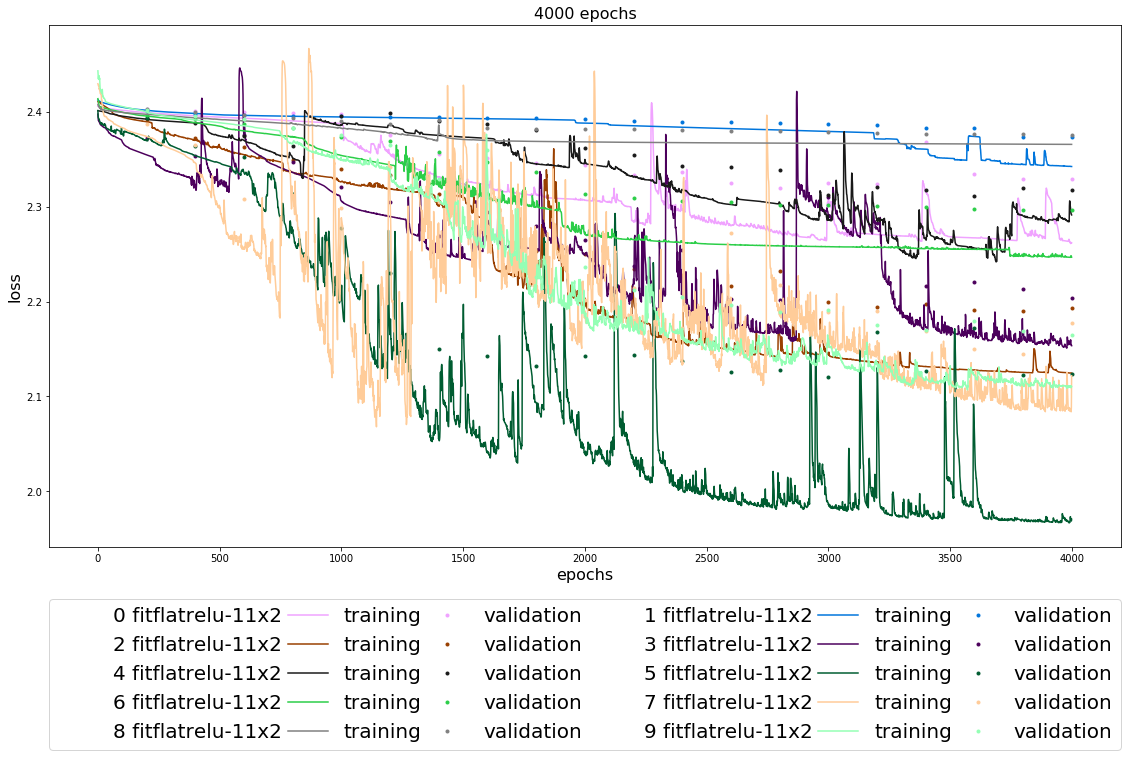

In [13]:
# show_graph(models, show_type)
fig, ax1, error, valid = show_graph(models, show_type)

if save_to_file:
    plt.savefig('data/'+models[0][0][0]+'.png', format='png')

plt.show()
plt.close()

In [14]:
to_file = []
for ii,mm in models.items():
    print('%s\t%3.2f %%'%(models[ii][0][0], results[ii]))
    to_file.append( results[ii] )

total_string = '({:.2f} ± {:.2f})%'.format(np.average(results[:]),np.std(results[:]))
print('\n%s'%total_string )

if save_to_file:
    np.savetxt( 'data/'+models[ii][0][0]+'_overview.csv' , to_file, fmt='%3.2f', delimiter="\t", header=total_string)
    
del to_file

fitflatrelu-11x2	23.16 %
fitflatrelu-11x2	20.13 %
fitflatrelu-11x2	29.00 %
fitflatrelu-11x2	29.87 %
fitflatrelu-11x2	18.83 %
fitflatrelu-11x2	33.77 %
fitflatrelu-11x2	21.43 %
fitflatrelu-11x2	25.11 %
fitflatrelu-11x2	15.80 %
fitflatrelu-11x2	26.84 %

(24.39 ± 5.28)%


In [15]:
### save data to csv files
if save_to_file:
    x = np.linspace(1,epochs,epochs).reshape(epochs,1)
    print(x.shape)

    yy = models[0][-1][:]
    for jj in range(rep-1):
         yy = np.vstack( (yy, models[jj+1][-1][:]) )
    print( yy.T.shape )

    dat = np.concatenate( (x, yy.T), axis=1 )
    print(dat.shape)

    np.savetxt( 'data/'+models[ii][0][0]+'_learn.csv' , dat, fmt='%.5f', delimiter="\t")

    x = np.linspace(epochs//20,epochs,20).reshape(20,1)
    print(x.shape)

    yy = models[0][-2][:]
    for jj in range(rep-1):
         yy = np.vstack( (yy, models[jj+1][-2][:]) )
    print( yy.T.shape )

    dat = np.concatenate( (x, yy.T), axis=1 )
    print(dat.shape)

    np.savetxt( 'data/'+models[ii][0][0]+'_valid.csv' , dat, fmt='%.5f', delimiter="\t")

(4000, 1)
(4000, 10)
(4000, 11)
(20, 1)
(20, 10)
(20, 11)
